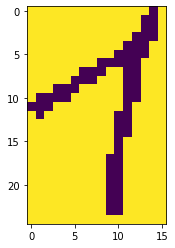

[array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.]])
 array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.]])
 array([[1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1.],
        [1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1.]])
 array([[1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1.],
        [1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.]])
 array([[1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1

In [2]:
from skimage import io
from skimage.transform import resize
import numpy as np
import scipy.ndimage as ndi
import matplotlib.pyplot as plt

# read in image as 8 bit grayscale
img = io.imread('baseProjetOCR/1_8.png')
resize(img, (60, 60), preserve_range=True).astype('uint8')

# specify a threshold 0-255
threshold = 150

# make all pixels < threshold black
binarized = 1.0 * (img > threshold)

#convert 3d array to 2d array
binarized = binarized[:,:,0]

imgplot = plt.imshow(binarized)
plt.show()

#print(binarized)

y_zoning = int(len(binarized)/3)
x_zoning = int(len(binarized[0])/3)

vector = []

lis = np.array_split(binarized,9,axis=0)
vectors = np.array(lis,dtype=object)
print(vectors)

